<a href="https://colab.research.google.com/github/ErickMBarreto/TechChallengeFase1/blob/main/TechChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics.pairwise import euclidean_distances

Função para gerar os dados

In [ ]:
n = 2000
generos = ['masculino', 'feminino']
fumantes = ['sim', 'não']
regioes = ['norte', 'nordeste', 'sul', 'sudeste', 'sudoeste']

def gerar_dados(n):
  idades = np.random.randint(18, 65, size=n)
  generos_rand = np.random.choice(generos, size=n)
  imcs = np.round(np.random.normal(loc=27, scale=5, size=n),2)
  filhos = np.random.randint(0, 5, size=n)
  fumantes_rand = np.random.choice(fumantes, size=n, p=[0.3, 0.7])
  regioes_rand = np.random.choice(regioes, size=n)

  encargos = []

  for i in range(n):
    base = 2000
    idade = idades[i]
    imc = imcs[i]
    filhos_qtd = filhos[i]
    fumante = fumantes_rand[i]
    regiao = regioes_rand[i]

    #Formula base para custo
    custo = base + idade * 200 + imc * 200 + filhos_qtd * 500

    #Custo em caso de fumante
    if fumante == 'sim':
      custo *= 2.8

    #Custo por região
    if regiao == 'norte':
      custo *= 1.0
    elif regiao == 'sul':
      custo *= 1.13
    elif regiao == 'sudeste':
      custo *= 1.40
    elif regiao == 'nordeste':
      custo *= 1.07
    else:
      custo *= 1.16

    #Aleatoriedade
    custo += np.random.normal(loc=0, scale=1000)
    encargos.append(round(custo, 2))

  df = pd.DataFrame({
      'idade': idades,
      'gênero': generos_rand,
      'imc': imcs,
      'filhos': filhos,
      'fumante': fumantes_rand,
      'região': regioes_rand,
      'encargos': encargos
  })

  return df

Gerar os dados

In [ ]:
df_gerado = gerar_dados(n=1000)

#Salvar no formato CSV
df_gerado.to_csv('dados_gerados.csv', index=False)
print(df_gerado.head())

   idade     gênero    imc  filhos fumante   região  encargos
0     63   feminino  19.82       4     não    norte  21706.59
1     51  masculino  26.83       2     sim  sudeste  72474.96
2     43  masculino  32.38       3     não      sul  21024.14
3     59  masculino  21.97       4     sim  sudeste  80380.57
4     18  masculino  29.09       4     não    norte  13141.12


Ler os dados gerados

In [ ]:
dataset = pd.read_csv("dados_gerados.csv")

In [ ]:
dataset.describe()

,idade,imc,filhos,encargos
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.349000,27.023120,1.961000,29998.970560
std,13.495827,4.937818,1.426715,17775.206172
min,18.000000,12.170000,0.000000,9404.330000
25%,29.000000,23.515000,1.000000,17394.992500
50%,42.000000,26.990000,2.000000,21502.570000
75%,53.000000,30.410000,3.000000,44489.025000
max,64.000000,41.740000,4.000000,88488.850000


Estética dos gráficos

In [ ]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
#Informações gerais da base
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     1000 non-null   int64  
 1   gênero    1000 non-null   object 
 2   imc       1000 non-null   float64
 3   filhos    1000 non-null   int64  
 4   fumante   1000 non-null   object 
 5   região    1000 non-null   object 
 6   encargos  1000 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 54.8+ KB


In [ ]:
#Como visto acima, não temos valores nulos, mas caso tivesse, teriamos que substituir pela mediana por exemplo.
dataset.isnull().sum()

,0
idade,0
gênero,0
imc,0
filhos,0
fumante,0
região,0
encargos,0


array([[<Axes: title={'center': 'idade'}>,
        <Axes: title={'center': 'imc'}>],
       [<Axes: title={'center': 'filhos'}>,
        <Axes: title={'center': 'encargos'}>]], dtype=object)

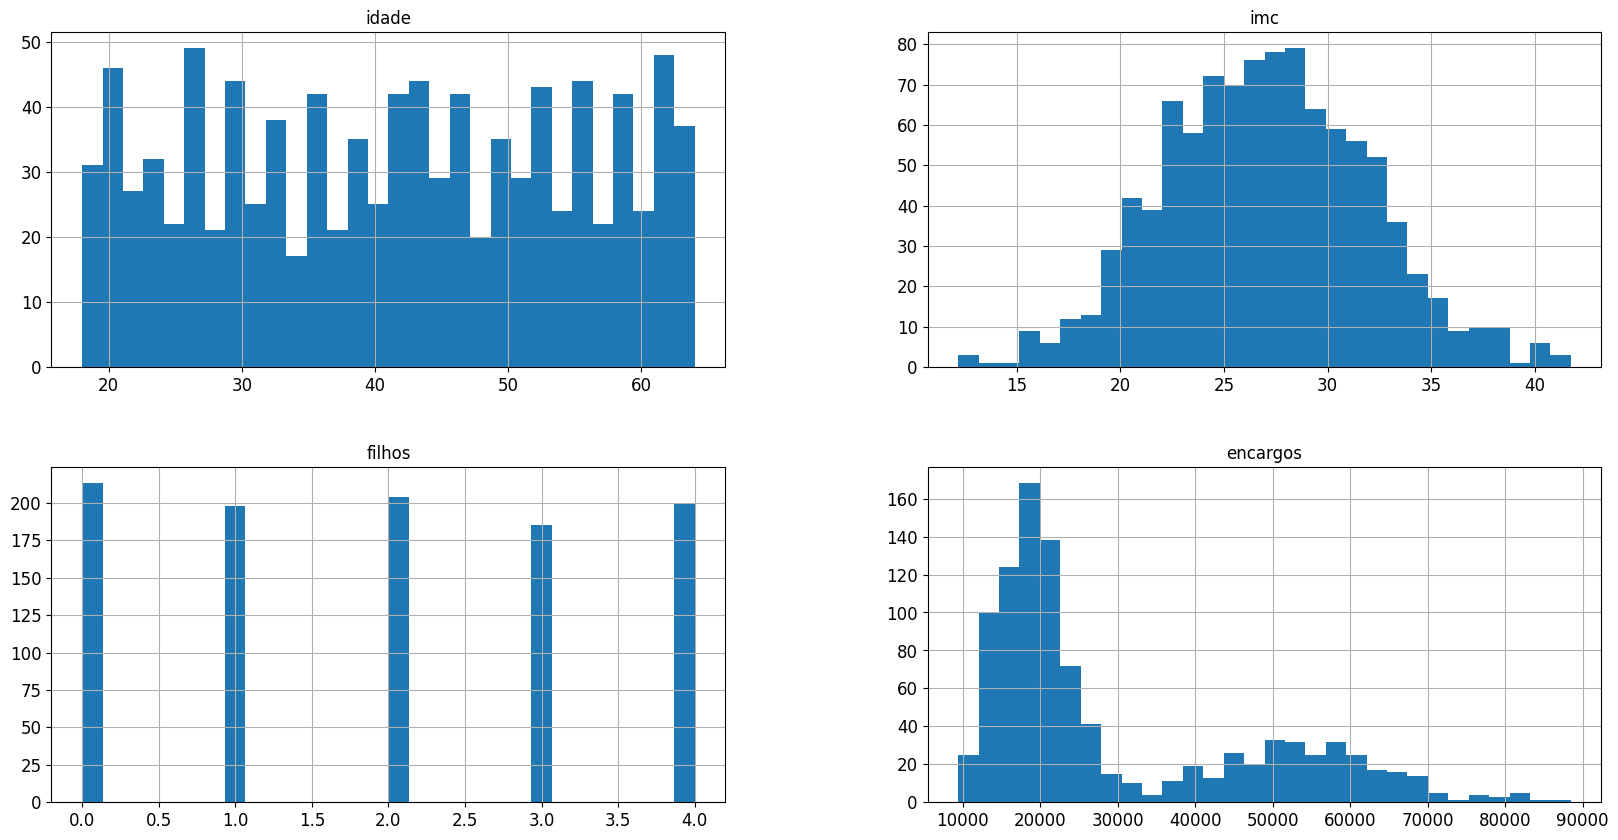

In [ ]:
#Gerar os gráficos dos dados
dataset.hist(bins=30,figsize=(20, 10))

In [ ]:
#Split da base treino e da base teste
df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=42)

In [ ]:
#Utilizando o OneHotEncoder para pré-processar as colunas categóricas

#colunas categóricas
cols = ['fumante', 'gênero', 'região']
encoder = OneHotEncoder(sparse_output=False)

X_cols_train = encoder.fit_transform(dataset[cols])
X_cols_test = encoder.transform(df_test[cols])

print(encoder.categories_)
X_cols_train[0]

[array(['não', 'sim'], dtype=object), array(['feminino', 'masculino'], dtype=object), array(['nordeste', 'norte', 'sudeste', 'sudoeste', 'sul'], dtype=object)]


array([1., 0., 1., 0., 0., 1., 0., 0., 0.])

Pipeline de pré-processamento dos dados

In [ ]:
#Colunas numericas, sem a coluna de 'encargos'
cols_num =['idade', 'imc', 'filhos']

#Colunas categoricas
cols_cat = ['fumante', 'gênero', 'região']

In [ ]:
#Utilizar o StadardScaler para padronizar o dados
pipeline_n = Pipeline([
    ('scaler', StandardScaler())
])
#Para evitar multicolinearidade utilizamos o Drop first para ajustar as colunas
pipeline_f = ColumnTransformer([
    ('num', pipeline_n, cols_num),
    ('cat', OneHotEncoder(drop='first'), cols_cat)
])

In [ ]:
#Aplicando na base treino
X_train_pre = pipeline_f.fit_transform(df_train)

In [ ]:
#Pega o nome das colunas numericas e os valores
features_num = cols_num
features_cat = pipeline_f.named_transformers_['cat'].get_feature_names_out(cols_cat)

#Concatena os nomes
features_all = list(features_num) + list(features_cat)

#Gera o DataFrame preparado
X_df_train = pd.DataFrame(X_train_pre, columns = features_all, index=df_train.index)

#Verificar os 5 primeiros valores
X_df_train.head()

#Nesse caso removemos o fumante_não, genero_feminino e criamos uma coluna pra cada regiao

,idade,imc,filhos,fumante_sim,gênero_masculino,região_norte,região_sudeste,região_sudoeste,região_sul
29,0.550527,-0.625525,0.765310,0.0,0.0,0.0,0.0,0.0,1.0
535,0.030198,-0.526103,0.765310,0.0,0.0,0.0,0.0,0.0,0.0
695,-0.638797,0.297110,-0.648658,1.0,0.0,0.0,0.0,0.0,0.0
557,-0.415799,0.513849,-1.355642,0.0,0.0,1.0,0.0,0.0,0.0
836,0.030198,0.233480,-1.355642,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
#Aplicando na base teste
X_test_pre = pipeline_f.transform(df_test)
X_df_test = pd.DataFrame(X_test_pre, columns=features_all, index=df_test.index)

y_train = df_train['encargos']
y_test = df_test['encargos']

Utilizando Regressão Linear para realizar a previsão

In [ ]:
#Chama a Regressão Linear e treina
lg = LinearRegression()
lg.fit(X_df_train, y_train)

LinearRegression()

In [ ]:
f_data = df_train.iloc[:5]
f_labels = y_train.iloc[:5]

f_data_pre = pipeline_f.transform(f_data)
print(f'Real:{list(f_labels)}')
print(f'Predictions:{lg.predict(f_data_pre)}')
#Valores bem proximos

Real:[20693.83, 17736.48, 45461.85, 14152.87, 19260.07]
Predictions:[21297.42187583 17771.00752738 48834.95344634 12864.66234133
 18166.26754413]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
#Verificação do RMSE, MAE, R2 e MAPE
y_train_preds= lg.predict(X_df_train)

def calc_mape(labels, predictions):
  return np.mean(np.abs((labels - predictions)/labels)) * 100

rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))
mae = mean_absolute_error(y_train, y_train_preds)
r2 = r2_score(y_train, y_train_preds)
mape = calc_mape(y_train, y_train_preds)

print('RMSE:', rmse)
print('MAE:', mae)
print('R²:', r2)
print('MAPE:', mape)

RMSE: 3495.6024573841646
MAE: 2564.0065593326317
R²: 0.960807400351714
MAPE: 9.926276770025327


In [ ]:
#Erro médio, R$3664.28 no valor dos encargos médicos, R$2797.02 pra cima ou pra baixo
#O modelo preve ~95% da variação dos encargos com base nas variáveis fornecidas.
#O modelo tem um erro médio de 10.9% sobre os valores reais dos encargos.

Teste

In [ ]:
#Selecionando uma lina na base teste e uma real
demo = df_test.iloc[[0]] #Não perder o formato de DF
true_value = y_test.iloc[0]

#Pré-processamendo da demo
demo_pre = pipeline_f.transform(demo)

#Predição
pred = lg.predict(demo_pre)[0]

print(f'Real: R${true_value:.2f}')
print(f'Prediction: R${pred:.2f}')

Real: R$13960.43
Prediction: R$12942.83


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
#Teste manual
new_data = pd.DataFrame([{
    'idade': 60,
    'gênero': 'feminino',
    'imc': 32.9,
    'filhos': 4,
    'fumante': 'sim',
    'região': 'sudoeste'
}])

#Pré-processamento do dado
data_pre = pipeline_f.transform(new_data)

pred = lg.predict(data_pre)[0]
print(f'Prediction: R${pred:.2f}')

Prediction: R$64388.42


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
#Verificar dados parecidos para comparar com o dado manual
proc_data = pipeline_f.transform(new_data)
ds_copy = dataset.copy()

#Pré-processamento da base, tirando o 'encargo'
X_ds_copy = pipeline_f.transform(ds_copy.drop('encargos', axis=1))

#Faz o calculo da distancia do dado no dataset
dist = euclidean_distances(X_ds_copy, proc_data).flatten()

#10 registros mais prarecidos
indices_prox = np.argsort(dist)[:10]
similar = dataset.iloc[indices_prox]

#Mostrar os resultados
print(similar[['idade', 'gênero', 'imc', 'filhos', 'fumante', 'região', 'encargos']])
print(f'\nMédia dos encargos: R${similar["encargos"].mean():.2f}')

     idade     gênero    imc  filhos fumante    região  encargos
539     50   feminino  32.98       4     sim  sudoeste  65026.33
343     64   feminino  36.68       4     sim  sudoeste  79718.38
328     62   feminino  30.01       3     sim  sudoeste  68879.20
592     60   feminino  29.37       3     sim  sudoeste  69559.37
351     61  masculino  30.90       4     sim  sudoeste  71525.57
682     55  masculino  29.55       4     sim  sudoeste  67356.09
392     50   feminino  29.22       3     sim  sudoeste  63596.21
561     64   feminino  31.98       3     não  sudoeste  23428.28
287     64  masculino  34.01       3     sim  sudoeste  74981.04
208     62   feminino  30.77       3     sim  nordeste  66443.40

Média dos encargos: R$65051.39


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


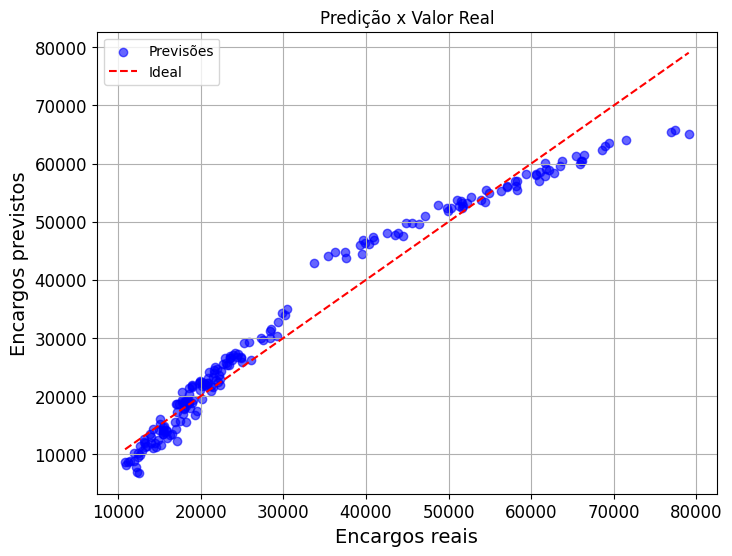

In [ ]:
#Gera as previsões
y_test_lg = lg.predict(X_test_pre)

#Grafico
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_lg, alpha=0.6, color='blue', label='Previsões')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('Encargos reais')
plt.ylabel('Encargos previstos')
plt.title('Predição x Valor Real')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#O pontos estão bem proximos da linha vermelha, indicando ótimas previsões.
#Os desvios em valores mais altos é típico para um modelo linear, ja que com linearidades complexas ele não captura muito bem.
#Mesmo assim, 95% é uma porcentagem excelente.